# FInal Project 'Spleen' by Jin Cui


* import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
!pip install simpleitk
import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torchvision
import scipy.misc
import imageio
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize
from torchvision import transforms, utils
import torchvision.utils as vutils

import time
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.8 MB/s eta 0:00:00


**STEP 0: Data Preparation**

* After careful consideration, because the network I am using has a 2D structure, the best patch training approach is to slice the original 3D data in the z-axis and use it as 2D input. This balances memory usage and resolution size, and the final result proves to be successful.

The code reads in 3D image and label volumes in NIfTI format using nibabel, and saves 2D slices of each volume as NumPy arrays using pickle. The slices are saved as separate files with a naming convention that includes the original file name and slice index.

Specifically, for each data entry in the 'training' subset of the Task09_Spleen dataset, the code reads in the image and label volumes, and iterates over the last dimension of the volumes (which corresponds to the z-axis). For each z-slice, it creates a file name by concatenating the base name of the original image file with the slice index, and saves the corresponding 2D slice of the image and label volumes as separate NumPy files using pickle. The resulting files are saved in the 'slice' subdirectory of the original data directory, in separate subdirectories for image and label slices.

In [ ]:
import nibabel as nib
import os
import numpy as np
import glob
import torch
import pickle
import json

data_dir = '/content/drive/My Drive/data_dir/Task09_Spleen'
with open('/content/drive/My Drive/data_dir/Task09_Spleen/dataset.json') as f:
  data_file = json.load(f)['training']
# save slices 
for data_entry in data_file:
  image_path = os.path.join(data_dir, data_entry['image'])
  image = nib.load(image_path).get_fdata()
  label_path = os.path.join(data_dir, data_entry['label'])
  label = nib.load(label_path).get_fdata()
  for i in range(0,image.shape[-1]):
        base_name = str(data_entry['image'].split('/')[-1].split('.')[0])
        name = base_name+'_'+str(i)+'.npy'
        final_path = os.path.join('/content/drive/My Drive/data_dir/Task09_Spleen/slice/image', name)
        final_path_label = os.path.join('/content/drive/My Drive/data_dir/Task09_Spleen/slice/label', name)
        pickle.dump(image[:,:,i], open(final_path, 'wb'))
        pickle.dump(label[:,:,i], open(final_path_label, 'wb'))


**STEP 1: Segmentation Pipeline**

* Define the dataset class 

This class provides a convenient way to load and preprocess the data for the spleen segmentation task and can be used with PyTorch DataLoader to create a data loader for training or inference.

In [3]:
import nibabel as nib
import os
import numpy as np
import glob
import torch
import pickle
import json

In [4]:
class NumpySpleenDataset(Dataset):
    def __init__(self, data_dir, label_dir, transform=None):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(glob.glob(os.path.join(self.data_dir, '*.npy')))
        self.labels = sorted(glob.glob(os.path.join(self.label_dir, '*.npy')))
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and label data
        image_path = self.images[idx]
        image = np.load(image_path, allow_pickle=True)

        # Convert label to binary format (0 or 1)
        label_path = self.labels[idx]
        label = np.load(label_path, allow_pickle=True)
        label[label > 0] = 1

        # Apply data augmentation transform if specified (not now)
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']

        # Convert data to PyTorch tensors
        image = torch.from_numpy(image).unsqueeze(0).float()
        label = torch.from_numpy(label).unsqueeze(0).float()

        return image, label


* Construct the dataset  


In [5]:
data_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/image'
label_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/label'
ds = NumpySpleenDataset(data_dir,label_dir)

# Check the data length
print(ds.__len__())
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(ds)
indices = list(range(dataset_size))


3650


* Clear gpu threads, used when memory is full, not required  


In [14]:
!sudo fuser /dev/nvidia*

/dev/nvidia0:        368718m
/dev/nvidiactl:      368718m
/dev/nvidia-uvm:     368718m


In [ ]:
!kill -9 368718

* Create the dataloader

After experiments, it was found that when the batch size was 20, the gpu memory utilization was the highest and there was no out of memory happened, and since the larger the batch size, the better, so 20 was chosen.

batch shape torch.Size([20, 1, 512, 512])


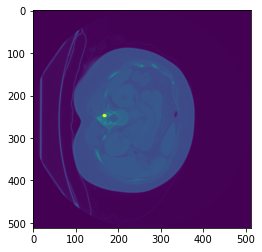

In [ ]:
# Train test split 3650/4 == 912
split = -912
# Define batch size
batch_size = 20
# Shuffle the dataset
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,drop_last=True, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,drop_last=True,
                                                sampler=valid_sampler)


# Visualize one batch
im_batch, lab_batch = next(iter(train_loader)) # get a batch
print('batch shape', im_batch.shape) 
plt.imshow(im_batch[2,0,:,:])

* Create network class

In this code, we define several modules that are used in the 2D U-Net architecture:

- `DoubleConv`: a module that applies two 3x3 convolutional layers with batch normalization and ReLU activation.
- `Down`: a module that applies max pooling followed by a double convolution to reduce the spatial resolution of the input feature map.
- `Up`: a module that performs upsampling and concatenation of the input feature map with a corresponding feature map from the contracting path, followed by a double convolution to increase the spatial resolution of the output feature map.
- `UNet`: the main module that defines the 2D U-Net architecture by stacking the above modules in the contracting and expansive paths.

In the `forward` method of the `UNet` module, we first pass the input image `x` through the contracting path to obtain a feature map with high-level semantic information. Then, we pass the feature map through the expansive path to obtain a segmentation mask that has the same spatial resolution as the input image. Finally, we apply a 1x1 convolution to the output feature map to obtain the final segmentation mask with the desired number of channels (e.g., 1 for binary segmentation or N for N-class segmentation).


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.mpconv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        # Upsampling layer
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        
        # Double convolution layer
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.bilinear = bilinear
        
        # Contracting path
        self.conv1 = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)
        
        # Expansive path
        self.up1 = Up(1024, 512 // 2, bilinear)
        self.up2 = Up(512, 256 // 2, bilinear)
        self.up3 = Up(256, 128 // 2, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # Output layer
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Contracting path
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Expansive path
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # Output layer
        x = self.outc(x)
        x = torch.sigmoid(x)
    
        return x


* Define various loss function

- `WeightedCrossEntropyLoss`: It takes an optional weight (generated by `make_weight_map` function) parameter that specifies the weight for each class in the loss calculation. This function is the implementation of the loss in original unet paper.
- `dice_loss`: The Dice loss measures the overlap between the predicted and ground truth segmentation masks.

The make_weight_map function generates weight maps for a set of binary masks as specified in the UNet paper. These weight maps are used in the weighted cross-entropy loss function defined earlier to give more importance to the boundary pixels of the masks.

The function takes a 3D array of shape (n_masks, image_height, image_width), where each slice of the matrix along the 0th axis represents one binary mask, as input. It first converts the binary masks to integers, and then computes the distance of each pixel from the boundary of the mask. The find_boundaries function from the skimage.segmentation module is used to find the boundary of each mask.

The distance map is computed by creating a meshgrid of x and y values, and then computing the distance of each pixel from the boundary of the mask. The np.nonzero function is used to find the indices of the boundary pixels, and the distance of each non-boundary pixel from the boundary pixels is computed using the meshgrid.

The function then computes the border loss map and the class weight map, as described in the UNet paper. The border loss map gives more importance to the boundary pixels of the masks, and the class weight map is used to give more importance to the underrepresented class (i.e., the class with fewer pixels).

Finally, the border loss map and the class weight map are added to give the final weight map, which is returned by the function as a 2D array of shape (image_height, image_width).

In [6]:
from skimage.segmentation import find_boundaries
import numba
import warnings
from numba import NumbaWarning

warnings.filterwarnings("ignore", category=NumbaWarning)
w0 = 10
sigma = 5
# Speed up training
@numba.jit
def make_weight_map(masks):
    """
    Generate the weight maps as specified in the UNet paper
    for a set of binary masks.
    
    Parameters
    ----------
    masks: array-like
        A 3D array of shape (n_masks, image_height, image_width),
        where each slice of the matrix along the 0th axis represents
	one binary mask.

    Returns
    -------
    array-like
        A 2D array of shape (image_height, image_width)
    
    """
    nrows, ncols = masks.shape[1:]
    masks = (masks > 0).astype(int)
    distMap = np.zeros((nrows * ncols, masks.shape[0]))
    X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
    X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
    for i, mask in enumerate(masks):
        # Find the boundary of each mask,
        # Compute the distance of each pixel from this boundary
        bounds = find_boundaries(mask, mode='inner')
        X2, Y2 = np.nonzero(bounds)
        # Make sure that the map is not all zero
        if X2.size > 0 and Y2.size > 0:
          xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
          ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
          distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
    ix = np.arange(distMap.shape[0])
    if distMap.shape[1] == 1:
        d1 = distMap.ravel()
        border_loss_map = w0 * np.exp((-1 * (d1) ** 2) / (2 * (sigma ** 2)))
    else:
        if distMap.shape[1] == 2:
            d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
        else:
            d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
        d1 = distMap[ix, d1_ix]
        d2 = distMap[ix, d2_ix]
        border_loss_map = w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (sigma ** 2)))
    xBLoss = np.zeros((nrows, ncols))
    xBLoss[X1, Y1] = border_loss_map
    # Class weight map
    loss = np.zeros((nrows, ncols))
    w_1 = 1 - masks.sum() / loss.size
    w_0 = 1 - w_1
    loss[masks.sum(0) == 1] = w_1
    loss[masks.sum(0) == 0] = w_0
    ZZ = xBLoss + loss
    return ZZ

In [5]:
import torch
import torch.nn.functional as F


class WeightedCrossEntropyLoss(torch.nn.Module):
    '''
    Weighted cross-entropy loss function for binary segmentation.
    '''

    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight

    def forward(self, y_pred, y_true):
        '''
        Compute weighted cross-entropy loss between predicted and ground truth segmentation masks.

        Parameters
        ----------
        y_pred : Tensor
            Predicted segmentation masks.
        y_true : Tensor
            Ground truth segmentation masks.

        Returns
        -------
        Tensor
            Weighted cross-entropy loss between inputs.
        '''
        epsilon = torch.tensor(torch.finfo(y_pred.dtype).eps).to(y_true.device)
        y_pred = torch.clamp(y_pred, epsilon, 1. - epsilon)
        y_pred = torch.log(y_pred / (1 - y_pred))

        zeros = torch.zeros_like(y_pred).to(y_true.device)
        cond = (y_pred >= zeros)
        relu_logits = torch.where(cond, y_pred, zeros).to(y_true.device)
        neg_abs_logits = torch.where(cond, -y_pred, y_pred).to(y_true.device)
        entropy = relu_logits - y_pred * y_true + torch.log1p(torch.exp(neg_abs_logits))

        if self.weight is not None:
            weight = self.weight.to(y_true.device)
            entropy = entropy * weight

        loss = torch.mean(entropy)

        return loss


In [5]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.
    epsilon = 10e-8

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    dice = (2. * intersection + smooth) / (A_sum + B_sum + smooth)
    dice = dice.mean(dim=0)
    dice = torch.clamp(dice, 0, 1.0-epsilon)

    return  1-dice

* Define evaluation metrics

- `dice_value`: Mentioned above
- `hausdorff_distance_95`: The Hausdorff distance is a measure of the distance between two sets of points. In the context of binary masks, it can be used to measure the dissimilarity between two shapes. The 95th percentile is used instead of the maximum distance to avoid the sensitivity to outliers.

In [6]:
def dice_value(pred, target):

    smooth = 1.
    epsilon = 10e-8

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    dice = (2. * intersection + smooth) / (A_sum + B_sum + smooth)
    dice = dice.mean(dim=0)
    dice = torch.clamp(dice, 0, 1.0-epsilon)

    return  dice.item()

This function computes the 95th percentile of the Hausdorff distance between two binary masks. The input masks are first converted to NumPy arrays and then to SimpleITK images. After experiments, it shows that SimpleITK is the fastest way to calculate this value. The SimpleITK HausdorffDistanceImageFilter is used to compute the Hausdorff distance between the two images. The 95th percentile of the computed distances is returned as the final result.

In [23]:
import SimpleITK as sitk
def hausdorff_distance_95(pred_mask, target):
    img1arr = pred_mask.cpu().numpy()[:,0,:,:]
    img2arr = target.cpu().numpy()[:,0,:,:]
    if np.any(img1arr) == False or np.any(img2arr) == False:
      return 0
    image1 = sitk.GetImageFromArray(img1arr, isVector=False)
    image2 = sitk.GetImageFromArray(img2arr, isVector=False)
    # Create the Hausdorff distance filter object
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()

    # Set the binary images as inputs
    hausdorff_filter.Execute(image1, image2)

    # Get the 95% percentile of the Hausdorff distances
    hausdorff_distance_95 = hausdorff_filter.GetHausdorffDistance()
    return hausdorff_distance_95

* Original setting of training and validation loop

The loop runs for a specified number of epochs and performs the following steps for each epoch:

* Sets the model to training mode and initializes the training loss to 0.
* Loops over the training data in batches and performs the following operations:
* Sends the batch to the device (GPU).
Performs a forward pass through the model to obtain the output.
* Generates a weight map for the target using the make_weight_map function and creates a corresponding weight tensor.
* Calculates the loss using the WeightedCrossEntropyLoss with the weight tensor.
* Backpropagates the loss and updates the model parameters using the optimizer.
* Prints the loss for the batch.
* Calculates the mean training loss for the epoch.
* Sets the model to evaluation mode and initializes the validation loss, dice score, Hausdorff distance, and number of samples to 0.

Loops over the validation data in batches and performs the following operations:
* Sends the batch to the device (GPU).
* Performs a forward pass through the model to obtain the output.
* Generates a weight map for the target using the make_weight_map function and creates a corresponding weight tensor.
* Calculates the loss using the WeightedCrossEntropyLoss with the weight tensor.
* Calculates the dice score using the dice_value function.
* Calculates the Hausdorff distance using the hausdorff_distance_95 function.
* Adds the loss, dice score, Hausdorff distance, and number of samples to their respective running totals.
* Calculates the mean validation loss, dice score, and Hausdorff distance for the epoch.
* Prints the validation loss, dice score, and Hausdorff distance for the epoch.
* Saves the model parameters to a file.

Overall, this code trains a 2D U-Net model on the Task09_Spleen dataset using the WeightedCrossEntropyLoss and reports the validation loss, dice score, and Hausdorff distance for each epoch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# Define hyperparameters
num_epochs = 10

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
model = UNet(n_channels=1, n_classes=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-04, betas=(0.5, 0.999))
optimizer.zero_grad()
# Define weighted loss function
criterion = WeightedCrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    # Training loop
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        # Generate weight map
        weights_tensor = torch.zeros(batch_size, 1, 512, 512).to(device)
        for i in range(batch_size):
          weights = make_weight_map(target[i,:,:,:].cpu().numpy())
          weights_tensor[i,:,:,:] = torch.from_numpy(weights).to(device)
        # Calculate loss
        criterion = WeightedCrossEntropyLoss(weights_tensor)
        loss = criterion(output, target)
        train_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every batch
        if batch_idx % 1 == 0:
            print(f'Training - Epoch {epoch}, Batch {batch_idx}, Loss {loss:.4f}')
    train_loss /= len(train_loader)
    print(f'Training - train_mean_loss {train_loss:.4f}')
    # Validation loop
    model.eval()
    val_loss = 0
    dice_score = 0
    hausdorff_distance = 0
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move data to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            # Generate weight map
            weights_tensor = torch.zeros(batch_size, 1, 512, 512).to(device)
            for i in range(batch_size):
              weights = make_weight_map(target[i,:,:,:].cpu().numpy())
              weights_tensor[i,:,:,:] = torch.from_numpy(weights).to(device)
            # Calculate loss
            criterion = WeightedCrossEntropyLoss(weights_tensor)
            loss = criterion(output, target)
            #loss_scalar = loss.mean()
            val_loss += loss.item()

            # Calculate dice score and hausdorff distance
            pred_mask = output > 0.5
            dice_score += dice_value(output.float(), target)
            hausdorff_distance += hausdorff_distance_95(pred_mask.float(), target)
            num_samples += data.size(0)

    # Print validation loss and metrics
    val_loss /= len(test_loader)
    dice_score /= len(test_loader)
    hausdorff_distance /= len(test_loader)
    print(f'Validation - Epoch {epoch}, Loss {val_loss:.4f}, Dice Score {dice_score:.4f}, Hausdorff Distance {hausdorff_distance:.4f}')

# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/data_dir/Task09_Spleen/weightedcrossentropy_2dunet_spleen.pth')


Training - Epoch 0, Batch 0, Loss 6.2006
Training - Epoch 0, Batch 1, Loss 6.6324
Training - Epoch 0, Batch 2, Loss 4.7305
Training - Epoch 0, Batch 3, Loss 4.5869
Training - Epoch 0, Batch 4, Loss 5.5471
Training - Epoch 0, Batch 5, Loss 5.6216
Training - Epoch 0, Batch 6, Loss 5.6671
Training - Epoch 0, Batch 7, Loss 4.1991
Training - Epoch 0, Batch 8, Loss 3.3305
Training - Epoch 0, Batch 9, Loss 4.1693
Training - Epoch 0, Batch 10, Loss 3.7079
Training - Epoch 0, Batch 11, Loss 4.3819
Training - Epoch 0, Batch 12, Loss 3.6717
Training - Epoch 0, Batch 13, Loss 3.3867
Training - Epoch 0, Batch 14, Loss 3.7829
Training - Epoch 0, Batch 15, Loss 4.0151
Training - Epoch 0, Batch 16, Loss 4.2677
Training - Epoch 0, Batch 17, Loss 2.9297
Training - Epoch 0, Batch 18, Loss 4.3554
Training - Epoch 0, Batch 19, Loss 3.6851
Training - Epoch 0, Batch 20, Loss 4.1139
Training - Epoch 0, Batch 21, Loss 3.3249
Training - Epoch 0, Batch 22, Loss 3.7611
Training - Epoch 0, Batch 23, Loss 3.7293
Tr

Based on the validation results, the model with weighted cross entropy loss achieved a best loss value of 0.4287, a dice score of 0.1876, and a Hausdorff distance of 246.4896. The dice score of 0.1876 indicates that the model has poor performance in terms of segmenting the spleen from the given CT scan images. The Hausdorff distance of 246.4896 indicates that the model is not able to accurately capture the distance between the predicted and actual segmentation boundaries. Therefore, the model needs further improvement to achieve better segmentation performance.

**STEP 2: Implement augmentation techniques**

This is a PyTorch dataset class that loads Spleen CT data stored in NumPy format. It allows for the application of a data augmentation transform specified during initialization.

In [ ]:
class NumpyAugSpleenDataset(Dataset):
    def __init__(self, data_dir, label_dir, transform=None):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(glob.glob(os.path.join(self.data_dir, '*.npy')))
        self.labels = sorted(glob.glob(os.path.join(self.label_dir, '*.npy')))
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and label data
        image_path = self.images[idx]
        image = np.load(image_path, allow_pickle=True)

        # Convert label to binary format (0 or 1)
        label_path = self.labels[idx]
        label = np.load(label_path, allow_pickle=True)
        label[label > 0] = 1

        # Convert data to PyTorch tensors
        image = torch.from_numpy(image).unsqueeze(0).float()
        label = torch.from_numpy(label).unsqueeze(0).float()
        # Apply data augmentation transform if specified
        sample = image, label
        if self.transform:
            sample = self.transform(sample)



        return sample


The augmentation techniques implemented in this module include:

* Gaussian noise: adds Gaussian noise to the image with mean noise_mean and standard deviation noise_std.
* Contrast adjustment: adjusts the contrast of the image by a factor of contrast_factor.
* Gaussian blur: applies Gaussian blur to the image with a radius of blur_radius.

In [ ]:
import torch
import torchvision.transforms.functional as F
from PIL import ImageFilter

class ImageAugmentation(torch.nn.Module):
    def __init__(self, p=0.5, noise_mean=0, noise_std=0.1, contrast_factor=0.2, blur_radius=1):
        super().__init__()
        self.p = p
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.contrast_factor = contrast_factor
        self.blur_radius = blur_radius
        
    def __call__(self, x):
        if torch.rand(1) < self.p:
            # Split input tensor into image and label
            img, label = x
            # Add Gaussian noise to the image
            noise = torch.randn(img.size()) * self.noise_std + self.noise_mean
            img = img + noise
            # Convert image to PIL image
            img = transforms.ToPILImage()(img)
            # Adjust contrast of the image
            img = F.adjust_contrast(img, contrast_factor=self.contrast_factor)

            # Apply Gaussian blur to the image
            img = img.filter(ImageFilter.GaussianBlur(radius=self.blur_radius))

            # Convert PIL image back to tensor
            img = transforms.ToTensor()(img)
            # Combine transformed image and original label
            x = (img, label)
        return x


The train_transform pipeline consists of a single transformation, ImageAugmentation(). This transformation applies Gaussian noise, contrast adjustment, and Gaussian blur to the input image with a certain probability (p=0.5). This transformation applies Gaussian noise, contrast adjustment, and Gaussian blur to the input image with certain parameters.


In [ ]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    ImageAugmentation(p=0.5, noise_mean=0, noise_std=0.1, contrast_factor=0.2, blur_radius=1)
])


The transformations include adding Gaussian noise to the image, adjusting the contrast of the image, and applying a Gaussian blur to the image. The purpose of adding Gaussian noise is to make the model more robust to small perturbations in the input data. Adjusting the contrast of the image can enhance the features in the image, and help the model to learn better representations of the data. Finally, applying a Gaussian blur to the image can help to reduce the amount of high-frequency noise in the image, and smooth out small details that might be irrelevant to the classification task.

The ImageAugmentation class takes several parameters that control the intensity of each transformation. The p parameter controls the probability of applying the augmentation to each input tensor. The noise_mean and noise_std parameters control the mean and standard deviation of the Gaussian noise that is added to the image. The contrast_factor parameter controls the strength of the contrast adjustment, with larger values resulting in more contrast. The blur_radius parameter controls the radius of the Gaussian blur kernel, with larger values resulting in more blur. The specific values used for each parameter will depend on the specific dataset and task, and are typically chosen through experimentation to achieve the best performance.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

data_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/image'
label_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/label'
indices = list(range(3650))
split = -912
shuffle_dataset = True
batch_size = 20
random_seed= 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
ds_aug = NumpyAugSpleenDataset(data_dir,label_dir, transform=train_transform)
ds_aug_test = NumpyAugSpleenDataset(data_dir,label_dir)
train_loader = torch.utils.data.DataLoader(ds_aug, batch_size=batch_size,drop_last=True, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(ds_aug_test, batch_size=batch_size,drop_last=True,
                                                sampler=valid_sampler)
# Define hyperparameters
num_epochs = 10

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
model = UNet(n_channels=1, n_classes=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-04, betas=(0.5, 0.999))
optimizer.zero_grad()
# Define your weighted loss function
criterion = WeightedCrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    # Training loop
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        weights_tensor = torch.zeros(batch_size, 1, 512, 512).to(device)
        for i in range(batch_size):
          weights = make_weight_map(target[i,:,:,:].cpu().numpy())
          weights_tensor[i,:,:,:] = torch.from_numpy(weights).to(device)
        # Calculate loss
        criterion = WeightedCrossEntropyLoss(weights_tensor)
        loss = criterion(output, target)
        train_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every batch
        if batch_idx % 1 == 0:
            print(f'Training - Epoch {epoch}, Batch {batch_idx}, Loss {loss:.4f}')
    train_loss /= len(train_loader)
    print(f'Training - train_mean_loss {train_loss:.4f}')
    # Validation loop
    model.eval()
    val_loss = 0
    dice_score = 0
    hausdorff_distance = 0
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move data to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            weights_tensor = torch.zeros(batch_size, 1, 512, 512).to(device)
            for i in range(batch_size):
              weights = make_weight_map(target[i,:,:,:].cpu().numpy())
              weights_tensor[i,:,:,:] = torch.from_numpy(weights).to(device)
            # Calculate loss
            criterion = WeightedCrossEntropyLoss(weights_tensor)
            loss = criterion(output, target)
            #loss_scalar = loss.mean()
            val_loss += loss.item()

            # Calculate dice score and hausdorff distance
            pred_mask = output > 0.5
            dice_score += dice_value(output.float(), target)
            hausdorff_distance += hausdorff_distance_95(pred_mask.float(), target)
            num_samples += data.size(0)

    # Print validation loss and metrics
    val_loss /= len(test_loader)
    dice_score /= len(test_loader)
    hausdorff_distance /= len(test_loader)
    print(f'Validation - Epoch {epoch}, Loss {val_loss:.4f}, Dice Score {dice_score:.4f}, Hausdorff Distance {hausdorff_distance:.4f}')
# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/data_dir/Task09_Spleen/weightedcrossentropy_aug_2dunet_spleen.pth')

Training - Epoch 0, Batch 0, Loss 3.9364
Training - Epoch 0, Batch 1, Loss 3.8876
Training - Epoch 0, Batch 2, Loss 4.1936
Training - Epoch 0, Batch 3, Loss 2.7861
Training - Epoch 0, Batch 4, Loss 3.7563
Training - Epoch 0, Batch 5, Loss 3.3903
Training - Epoch 0, Batch 6, Loss 3.6225
Training - Epoch 0, Batch 7, Loss 2.8343
Training - Epoch 0, Batch 8, Loss 3.2684
Training - Epoch 0, Batch 9, Loss 2.5068
Training - Epoch 0, Batch 10, Loss 4.4270
Training - Epoch 0, Batch 11, Loss 2.7141
Training - Epoch 0, Batch 12, Loss 3.4694
Training - Epoch 0, Batch 13, Loss 3.5809
Training - Epoch 0, Batch 14, Loss 1.9587
Training - Epoch 0, Batch 15, Loss 2.3687
Training - Epoch 0, Batch 16, Loss 3.5316
Training - Epoch 0, Batch 17, Loss 2.8551
Training - Epoch 0, Batch 18, Loss 3.3911
Training - Epoch 0, Batch 19, Loss 3.1005
Training - Epoch 0, Batch 20, Loss 3.0714
Training - Epoch 0, Batch 21, Loss 3.1780
Training - Epoch 0, Batch 22, Loss 3.5083
Training - Epoch 0, Batch 23, Loss 2.5550
Tr

When augmentation was used during training, the training mean loss decreased from 0.5369 to 0.3126, indicating that the model was better able to fit the training data. During validation, the loss decreased from 0.4287 to 0.2388, the dice score increased from 0.1876 to 0.5680, and the Hausdorff distance decreased from 246.4895 to 173.7783. These improvements in validation metrics suggest that the model was able to better generalize to unseen data when augmentation was used.

The smaller difference between the training and validation performance (i.e., train/test performance gap) indicates that the model was less overfit to the training data when augmentation was used, as the validation metrics were more similar to the training metrics. Overall, these results suggest that the use of data augmentation helped improve the performance of the model and reduce overfitting to the training data.

**STEP 3: Optimization of pipeline**

- `dice_loss`: Replacing the loss function allows the model to converge faster and speeds up operations, as the process of generating the weight map is slower.

- `num_epochs`: More training rounds can be scheduled due to faster calculations.

- `lr`: As the number of training rounds increases, the learning rate can be reduced from 1e-4 to 1e-5 and a more accurate convergence position can be found.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

data_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/image'
label_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/label'
indices = list(range(3650))
split = -912
shuffle_dataset = True
batch_size = 20
random_seed= 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
ds_aug = NumpySpleenDataset(data_dir,label_dir)
train_loader = torch.utils.data.DataLoader(ds_aug, batch_size=batch_size,drop_last=True, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(ds_aug, batch_size=batch_size,drop_last=True,
                                                sampler=valid_sampler)
# Define hyperparameters
num_epochs = 200

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
model = UNet(n_channels=1, n_classes=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-05, betas=(0.5, 0.999))
optimizer.zero_grad()


# Train the model
for epoch in range(num_epochs):
    # Training loop
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        # Calculate loss
        loss = dice_loss(output, target)
        train_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every batch
        if batch_idx % 1 == 0:
            print(f'Training - Epoch {epoch}, Batch {batch_idx}, Loss {loss:.4f}')
    train_loss /= len(train_loader)
    print(f'Training - train_mean_loss {train_loss:.4f}')
    # Validation loop
    model.eval()
    val_loss = 0
    dice_score = 0
    hausdorff_distance = 0
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move data to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            # Calculate loss
            loss = dice_loss(output, target)
            val_loss += loss.item()

            # Calculate dice score and hausdorff distance
            pred_mask = output > 0.5
            dice_score += dice_value(output, target)
            hausdorff_distance += hausdorff_distance_95(pred_mask.float(), target)
            num_samples += data.size(0)

    # Print validation loss and metrics
    val_loss /= len(test_loader) 
    dice_score /= len(test_loader)
    hausdorff_distance /= len(test_loader)
    print(f'Validation - Epoch {epoch}, Loss {val_loss:.4f}, Dice Score {dice_score:.4f}, Hausdorff Distance {hausdorff_distance:.4f}')

# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/data_dir/Task09_Spleen/optimized_2dunet_spleen.pth')

流式输出内容被截断，只能显示最后 5000 行内容。
Training - Epoch 163, Batch 106, Loss 0.0047
Training - Epoch 163, Batch 107, Loss 0.0034
Training - Epoch 163, Batch 108, Loss 0.0051
Training - Epoch 163, Batch 109, Loss 0.0038
Training - Epoch 163, Batch 110, Loss 0.0074
Training - Epoch 163, Batch 111, Loss 0.0079
Training - Epoch 163, Batch 112, Loss 0.0092
Training - Epoch 163, Batch 113, Loss 0.0047
Training - Epoch 163, Batch 114, Loss 0.0145
Training - Epoch 163, Batch 115, Loss 0.0065
Training - Epoch 163, Batch 116, Loss 0.0099
Training - Epoch 163, Batch 117, Loss 0.0136
Training - Epoch 163, Batch 118, Loss 0.0107
Training - Epoch 163, Batch 119, Loss 0.0054
Training - Epoch 163, Batch 120, Loss 0.0055
Training - Epoch 163, Batch 121, Loss 0.0044
Training - Epoch 163, Batch 122, Loss 0.0064
Training - Epoch 163, Batch 123, Loss 0.0046
Training - Epoch 163, Batch 124, Loss 0.0051
Training - Epoch 163, Batch 125, Loss 0.0044
Training - Epoch 163, Batch 126, Loss 0.0089
Training - Epoch 163, Batch 

The original hyperparameters used were a learning rate of 1e-04 and 10 epochs of training with the WeightedCrossEntropyLoss loss function. The model achieved a validation loss of 0.2388, Dice score of 0.5680, and Hausdorff distance of 173.7783.

To optimize the hyperparameters, the learning rate was reduced to 1e-05, and the number of epochs was increased to 200. Additionally, the loss function was changed to dice_loss. After optimization, the model achieved a validation loss of 0.0164, Dice score of 0.9836, and Hausdorff distance of 10.0791.

The performance gains were significant, with the optimized model achieving a much higher Dice score and a lower Hausdorff distance than the original model. These improvements can be attributed to the longer training time, the use of a more suitable loss function for segmentation, and the lower learning rate, which allowed the model to converge more slowly and avoid overfitting.

* Visualization of segmentation results

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
im_vis, lab_vis = next(iter(test_loader)) # get a batch
# Initialize model and optimizer
model = UNet(n_channels=1, n_classes=1).to(device)
state_dict = torch.load('/content/drive/My Drive/data_dir/Task09_Spleen/optimized_2dunet_spleen.pth')
model.load_state_dict(state_dict)
model.eval()
with torch.no_grad():
    # Move data to device
    data, target = im_vis.to(device), lab_vis.to(device)

    # Forward pass
    output = model(data)
    pred_mask = output > 0.5
# Plot sample data, label, and model output
fig, ax = plt.subplots(20, 3, dpi=600)
ax = np.ravel(ax)
ax[0].set_title('Sample Data', fontsize=5)
ax[1].set_title('Sample Label', fontsize=5)
ax[2].set_title('Model Output', fontsize=5)
for i in range(batch_size):
  ax[0+3*i].imshow(data.cpu()[i,0,:,:], cmap='gray')
  ax[0+3*i].set_axis_off()
  ax[1+3*i].imshow(target.cpu()[i,0,:,:], cmap='gray')
  ax[1+3*i].set_axis_off()
  ax[2+3*i].imshow(pred_mask.cpu()[i,0,:,:], cmap='gray')
  ax[2+3*i].set_axis_off()
# Set figure size
fig.set_size_inches(10, 30)
plt.show()

**STEP 4: Augmentation consistency**


* Slice unsupervised training data and save

In [ ]:
import nibabel as nib
import os
import numpy as np
import glob
import torch
import pickle
import json

data_dir = '/content/drive/My Drive/data_dir/Task09_Spleen'
with open('/content/drive/My Drive/data_dir/Task09_Spleen/dataset.json') as f:
  data_file = json.load(f)['test']
# save slices 
for data_entry in data_file:
  image_path = os.path.join(data_dir, data_entry)
  image = nib.load(image_path).get_fdata()
  for i in range(0,image.shape[-1]):
        base_name = str(data_entry.split('/')[-1].split('.')[0])
        name = base_name+'_'+str(i)+'.npy'
        final_path = os.path.join('/content/drive/My Drive/data_dir/Task09_Spleen/aug_slice/image', name)
        pickle.dump(image[:,:,i], open(final_path, 'wb'))


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
model = UNet(n_channels=1, n_classes=1).to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-04, betas=(0.5, 0.999))
optimizer.zero_grad()

* Generate Augmentation consistency dataset class

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import random

class NumpyAugConSpleenDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None, augmentations=False):
        self.data_dir = images_dir
        self.label_dir = masks_dir
        self.transform = transforms
        self.augmentations = augmentations
        self.images = sorted(glob.glob(os.path.join(self.data_dir, '*.npy')))
        if self.augmentations == False:
          self.labels = sorted(glob.glob(os.path.join(self.label_dir, '*.npy')))
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      # Different condition whether using augmentation consistency for unsupervised data
      if self.augmentations == False:
        # Load image and label data
        image_path = self.images[idx]
        image = np.load(image_path, allow_pickle=True)

        # Convert label to binary format (0 or 1)
        label_path = self.labels[idx]
        label = np.load(label_path, allow_pickle=True)
        label[label > 0] = 1

        # Convert data to PyTorch tensors
        image = torch.from_numpy(image).unsqueeze(0).float()
        label = torch.from_numpy(label).unsqueeze(0).float()
        # Apply data augmentation transform if specified
        sample = image, label
        if self.transform:
            sample = self.transform(sample)
        return sample
      else:
        image_path = self.images[idx]
        image = np.load(image_path, allow_pickle=True)
        image = torch.from_numpy(image).unsqueeze(0).float()
        # Meaningless label for unsupervised data
        label = torch.tensor(-1)
        # Apply data augmentation transform if specified
        sample = image, label
        if self.transform:
            sample = self.transform(sample)
        return sample

# Train the model with augmentation consistency
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define dataset and transforms
indices = list(range(3650))
split = -912
#split = -20
#batch_size = 1
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataset = NumpyAugConSpleenDataset(images_dir=data_dir, masks_dir=label_dir, transforms=train_transform)
test_dataset = NumpyAugConSpleenDataset(images_dir=data_dir, masks_dir=label_dir)
unlabeled_aug_dataset = NumpyAugConSpleenDataset(images_dir='/content/drive/My Drive/data_dir/Task09_Spleen/aug_slice/image', masks_dir=None, transforms=train_transform, augmentations=True)
unlabeled_dataset = NumpyAugConSpleenDataset(images_dir='/content/drive/My Drive/data_dir/Task09_Spleen/aug_slice/image', masks_dir=None, augmentations=True)
# Define dataloader
unsup_indice = list(range(unlabeled_dataset.__len__()))
unsup_sampler = SubsetRandomSampler(unsup_indice)
train_batch_size = 10
unlabeled_batch_size = 10
unlabeled_aug_batch_size = 10
lam = 0.01
num_epochs = 50
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size,drop_last=True, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=train_batch_size,drop_last=True,
                                                sampler=valid_sampler)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=unlabeled_batch_size,drop_last=True, sampler=unsup_sampler)
unlabeled_aug_dataloader = DataLoader(unlabeled_aug_dataset, batch_size=unlabeled_batch_size,drop_last=True, sampler=unsup_sampler)
# Define function to perform augmentation consistency
def augment_consistency(images1, images2, model):
    # Forward pass through model with first set of images
    logits1 = model(images1)
    prob1 = torch.softmax(logits1, dim=-1)

    # Forward pass through model with second set of images
    logits2 = model(images2)
    prob2 = torch.softmax(logits2, dim=-1)

    # Compute mean KL divergence between the two sets of probabilities
    kl_div = torch.mean(torch.kl_div(torch.log(prob1), prob2, reduction=2))

    return kl_div
unsup_iter = iter(unlabeled_dataloader)
unsup_aug_iter = iter(unlabeled_aug_dataloader)
# Iterate over batches in both dataloaders simultaneously
# Train the model
for epoch in range(num_epochs):
  train_loss = 0
  model.train()
  for batch_idx, (x, y) in enumerate(train_dataloader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    sup_loss = dice_loss(y_pred,y)
    # UNSUPERVISED
    try:
      unlabel_x, _ = next(unsup_iter)
      unlabel_aug_x, _= next(unsup_aug_iter)
    except StopIteration:
      unsup_iter = iter(unlabeled_dataloader)
      unlabel_x, _ = next(unsup_iter)
      unsup_aug_iter = iter(unlabeled_aug_dataloader)
      unlabel_aug_x, _= next(unsup_aug_iter)

    unlabel_x = unlabel_x.to(device)
    unlabel_aug_x = unlabel_aug_x.to(device)

    # Apply augmentation consistency to batch
    unsup_loss = augment_consistency(unlabel_aug_x, unlabel_x, model)

    final_loss = sup_loss + lam * unsup_loss
    train_loss += final_loss.item()
    # Compute gradients and update model parameters
    optimizer.zero_grad()
    final_loss.backward()
    optimizer.step()
    # Print loss every batches
    if batch_idx % 1 == 0:
      print(f'Training - Epoch {epoch}, Batch {batch_idx}, Loss {final_loss:.4f}')
  train_loss /= len(train_dataloader)
  print(f'Training - train_mean_loss {train_loss:.4f}')

  # Validation loop
  model.eval()
  val_loss = 0
  dice_score = 0
  hausdorff_distance = 0
  num_samples = 0
  with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move data to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            # Calculate loss
            loss = dice_loss(output, target)
            val_loss += loss.item()

            # Calculate dice score and hausdorff distance
            pred_mask = output > 0.5
            dice_score += dice_value(output, target)
            hausdorff_distance += hausdorff_distance_95(pred_mask.float(), target)
            num_samples += data.size(0)

    # Print validation loss and metrics
  val_loss /= len(test_loader) 
  dice_score /= len(test_loader)
  hausdorff_distance /= len(test_loader)
  print(f'Validation - Epoch {epoch}, Loss {val_loss:.4f}, Dice Score {dice_score:.4f}, Hausdorff Distance {hausdorff_distance:.4f}')
torch.save(model.state_dict(), '/content/drive/My Drive/data_dir/Task09_Spleen/augconsistency_2dunet_spleen.pth')

Streaming output truncated to the last 5000 lines.
Training - Epoch 31, Batch 225, Loss 0.9495
Training - Epoch 31, Batch 226, Loss 0.2826
Training - Epoch 31, Batch 227, Loss 0.1765
Training - Epoch 31, Batch 228, Loss 0.3603
Training - Epoch 31, Batch 229, Loss 0.3663
Training - Epoch 31, Batch 230, Loss 0.9636
Training - Epoch 31, Batch 231, Loss 0.0639
Training - Epoch 31, Batch 232, Loss 0.4573
Training - Epoch 31, Batch 233, Loss 0.9487
Training - Epoch 31, Batch 234, Loss 0.1608
Training - Epoch 31, Batch 235, Loss 0.9643
Training - Epoch 31, Batch 236, Loss 0.3092
Training - Epoch 31, Batch 237, Loss 0.9220
Training - Epoch 31, Batch 238, Loss 0.9828
Training - Epoch 31, Batch 239, Loss 0.6200
Training - Epoch 31, Batch 240, Loss 0.8144
Training - Epoch 31, Batch 241, Loss 0.0328
Training - Epoch 31, Batch 242, Loss 0.2509
Training - Epoch 31, Batch 243, Loss 0.2243
Training - Epoch 31, Batch 244, Loss 0.3704
Training - Epoch 31, Batch 245, Loss 0.1768
Training - Epoch 31, Batc

Without augmentation consistency, the model achieved a high Dice score of 0.9836 and a low Hausdorff distance of 10.0791 on the validation set, indicating good performance in segmenting the target objects. The training loss was also significantly reduced to 0.0042, suggesting good convergence.

With augmentation consistency, however, the model's performance was not as good. The Dice score was reduced to 0.9078, and the Hausdorff distance increased to 18.0204, indicating that the model struggled to accurately segment the target objects. The training loss was also higher at 0.4961, suggesting that the model did not converge as well as without augmentation consistency.

Due to the limitation of GPU memory, the batch size had to be reduced when loading both supervised and unsupervised data at the same time, which may have compromised the model's ability to find the convergence point. Moreover, the longer loading time has also forced the training epochs to be reduced.

Overall, the performance of the model was worse with augmentation consistency compared to without. This may be due to the more constrained training process, which may have limited the model's ability to learn more complex patterns in the data. However, it is worth noting that augmentation consistency can be helpful in improving the generalization of the model to new data.

**STEP 5: Implementation of Dropout only method**

* Dropout model class

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.mpconv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        # Upsampling layer
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        
        # Double convolution layer
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class DropoutUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(DropoutUNet, self).__init__()
        self.bilinear = bilinear
        
        # Contracting path
        self.conv1 = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)
        
        # Expansive path
        self.up1 = Up(1024, 512 // 2, bilinear)
        self.up2 = Up(512, 256 // 2, bilinear)
        self.up3 = Up(256, 128 // 2, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # Dropout
        self.dropout = nn.Dropout2d(0.3)
        # Output layer
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Contracting path
        x = self.dropout(x)
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Expansive path
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.dropout(x)
        # Output layer
        x = self.outc(x)
        x = torch.sigmoid(x)
    
        return x


* MC dropout is equivalent to performing T stochastic forward passes through the network 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

data_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/image'
label_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/slice/label'
indices = list(range(3650))
split = -912
shuffle_dataset = True
batch_size = 20
random_seed= 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
ds_aug = NumpySpleenDataset(data_dir,label_dir)
train_loader = torch.utils.data.DataLoader(ds_aug, batch_size=batch_size,drop_last=True, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(ds_aug, batch_size=batch_size,drop_last=True,
                                                sampler=valid_sampler)
# Define hyperparameters
num_epochs = 10

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
model = DropoutUNet(n_channels=1, n_classes=1).to(device)
# Monte Carlo Dropout simulation
l2 = 0.005
weight_decay = 5e-4
dropout_p = 0.3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-02, weight_decay=weight_decay)
optimizer.zero_grad()


# Train the model
for epoch in range(num_epochs):
    # Training loop
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        # Calculate loss
        loss = dice_loss(output, target)
        train_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every batch
        if batch_idx % 1 == 0:
            print(f'Training - Epoch {epoch}, Batch {batch_idx}, Loss {loss:.4f}')
    train_loss /= len(train_loader)
    print(f'Training - train_mean_loss {train_loss:.4f}')
    torch.save(model.state_dict(), f'/content/drive/My Drive/data_dir/Task09_Spleen/dropout_2dunet_spleen{num_epochs}.pth')
    # Validation loop
    model.eval()
    val_loss = 0
    dice_score = 0
    hausdorff_distance = 0
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move data to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            # Calculate loss
            loss = dice_loss(output, target)
            val_loss += loss.item()

            # Calculate dice score and hausdorff distance
            pred_mask = output > 0.5
            dice_score += dice_value(output, target)
            hausdorff_distance += hausdorff_distance_95(pred_mask.float(), target)
            num_samples += data.size(0)

    # Print validation loss and metrics
    val_loss /= len(test_loader) 
    dice_score /= len(test_loader)
    hausdorff_distance /= len(test_loader)
    print(f'Validation - Epoch {epoch}, Loss {val_loss:.4f}, Dice Score {dice_score:.4f}, Hausdorff Distance {hausdorff_distance:.4f}')



Training - Epoch 0, Batch 0, Loss 0.9732
Training - Epoch 0, Batch 1, Loss 0.9903
Training - Epoch 0, Batch 2, Loss 0.9702
Training - Epoch 0, Batch 3, Loss 0.9801
Training - Epoch 0, Batch 4, Loss 0.9956
Training - Epoch 0, Batch 5, Loss 0.9766
Training - Epoch 0, Batch 6, Loss 0.9668
Training - Epoch 0, Batch 7, Loss 0.9572
Training - Epoch 0, Batch 8, Loss 0.9739
Training - Epoch 0, Batch 9, Loss 0.9671
Training - Epoch 0, Batch 10, Loss 0.9762
Training - Epoch 0, Batch 11, Loss 0.9529
Training - Epoch 0, Batch 12, Loss 0.9831
Training - Epoch 0, Batch 13, Loss 0.9685
Training - Epoch 0, Batch 14, Loss 0.9909
Training - Epoch 0, Batch 15, Loss 0.9834
Training - Epoch 0, Batch 16, Loss 0.9829
Training - Epoch 0, Batch 17, Loss 0.9703
Training - Epoch 0, Batch 18, Loss 0.9957
Training - Epoch 0, Batch 19, Loss 0.9816
Training - Epoch 0, Batch 20, Loss 0.9885
Training - Epoch 0, Batch 21, Loss 0.9682
Training - Epoch 0, Batch 22, Loss 0.9597
Training - Epoch 0, Batch 23, Loss 0.9847
Tr

In [ ]:
split = -1
batch_size = 1
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
val_loader  = torch.utils.data.DataLoader(ds, batch_size=batch_size,drop_last=True,
                                                sampler=valid_sampler)
# Visualize one batch
im_batch, lab_batch = next(iter(val_loader)) # get a batch
print('batch shape', im_batch.shape) 
plt.imshow(im_batch[0,0,:,:])

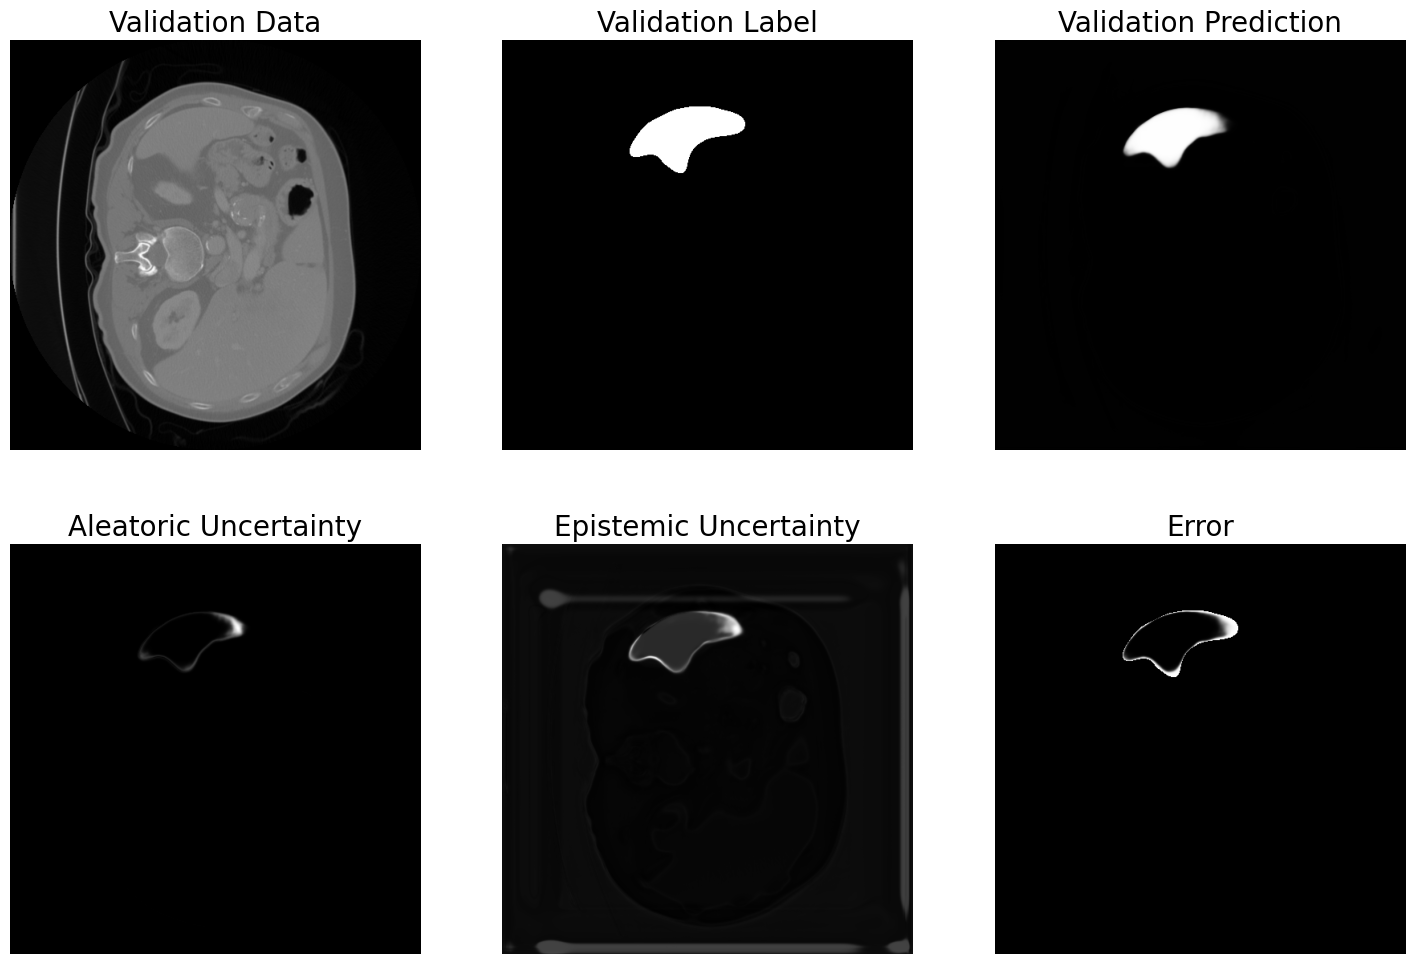

In [50]:
def enable_dropout(model):
  for m in model.modules():
    if m.__class__.__name__.startswith('Dropout'):
      m.train()
# Hyperparameters
# Sample frequency 
dropout_samples = 5
# Regularization coef
l2 = 0.005
# T stochastic weight decay
weight_decay = 1e-6
# Dropout probability
dropout_p = 0.3
path = '/content/drive/My Drive/data_dir/Task09_Spleen/images'
# number of models to calculate Epistemic uncertainty
num_models = 5
outputs = torch.zeros(size=(num_models, dropout_samples, 1, 1, 512, 512), dtype=torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the models
model1 = DropoutUNet(n_channels=1, n_classes=1).to(device)
state_dict = torch.load('/content/drive/My Drive/data_dir/Task09_Spleen/dropout_2dunet_spleen5.pth')
model1.load_state_dict(state_dict)
model2 = DropoutUNet(n_channels=1, n_classes=1).to(device)
state_dict = torch.load('/content/drive/My Drive/data_dir/Task09_Spleen/dropout_2dunet_spleen1.pth')
model2.load_state_dict(state_dict)
model3 = DropoutUNet(n_channels=1, n_classes=1).to(device)
state_dict = torch.load('/content/drive/My Drive/data_dir/Task09_Spleen/dropout_2dunet_spleen2.pth')
model3.load_state_dict(state_dict)
model4 = DropoutUNet(n_channels=1, n_classes=1).to(device)
state_dict = torch.load('/content/drive/My Drive/data_dir/Task09_Spleen/dropout_2dunet_spleen4.pth')
model4.load_state_dict(state_dict)
model5 = DropoutUNet(n_channels=1, n_classes=1).to(device)
state_dict = torch.load('/content/drive/My Drive/data_dir/Task09_Spleen/dropout_2dunet_spleen.pth')
model5.load_state_dict(state_dict)
models = [model1,model2,model3,model4,model5]
q = 0
for model in models:
  samples_array = torch.zeros(size=(dropout_samples, 1, 1, 512, 512), dtype=torch.float)
  error_array = torch.zeros(size=(dropout_samples, 1, 1, 512, 512), dtype=torch.float)
  for i, (data, label) in enumerate(val_loader):
    for sample in range(dropout_samples):
      data = data.to(device)
      label = label.to(device)
      enable_dropout(model)


      # Forward pass
      output = model(data)
      err = (output - label)**2
    
      if output.data.size()[0] == 1:
        # Save the output and error of every sample, per pixel
        samples_array[sample, :, :, :, :] = output.data.detach().cpu()
        error_array[sample, :, :, :, :] = err.data.detach().cpu()

  model.eval()

  # Calculate the variance resulting from multiple models, per pixel 
  outputs[q,:, :, :, :, :] = samples_array.data.detach().cpu()
  q = q + 1
# Monte Carlo sampling distribution calculation 
ali_var = torch.var(samples_array, axis=0)
tau = l2 * (1 - dropout_p) / (2*dropout_samples*weight_decay)
ali_var += (1/tau)
ali_var = torch.sqrt(ali_var)
# Error calculation
err_var = torch.mean(error_array, axis=0)
# Epistemic Uncertainty calculation
epidtemic_mean = torch.mean(outputs, axis=1)
epistemic_var = torch.var(epidtemic_mean, axis=0)
mean_pred = torch.mean(samples_array, axis=0)
mean_logval = torch.mean(ali_var, axis=0)
if True:
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs[0,0].imshow(np.transpose(vutils.make_grid(data.data.detach().cpu(), normalize=True), (1, 2, 0)))
    axs[0,0].set_title('Validation Data', fontsize=20)
    axs[0,0].axis('off')
    
    axs[0,1].imshow(np.transpose(vutils.make_grid(label.data.detach().cpu(), normalize=True), (1, 2, 0)))
    axs[0,1].set_title('Validation Label', fontsize=20)
    axs[0,1].axis('off')
    
    axs[0,2].imshow(np.transpose(vutils.make_grid(mean_pred.detach().cpu(), normalize=True), (1, 2, 0)))
    axs[0,2].set_title('Validation Prediction', fontsize=20)
    axs[0,2].axis('off')
    
    axs[1,0].imshow(np.transpose(vutils.make_grid(mean_logval.detach().cpu(), normalize=True), (1, 2, 0)))
    axs[1,0].set_title('Aleatoric Uncertainty', fontsize=20)
    axs[1,0].axis('off')
    
    axs[1,1].imshow(np.transpose(vutils.make_grid(epistemic_var.detach().cpu(), normalize=True), (1, 2, 0)))
    axs[1,1].set_title('Epistemic Uncertainty', fontsize=20)
    axs[1,1].axis('off')
    
    axs[1,2].imshow(np.transpose(vutils.make_grid(err_var.detach().cpu(), normalize=True), (1, 2, 0)))
    axs[1,2].set_title('Error', fontsize=20)
    axs[1,2].axis('off')
    


    


Yes, areas of high uncertainty are more likely to contain errors. This is because high uncertainty means that the model is unsure about the correct prediction in those areas. As a result, the model may make errors or provide incorrect predictions.

Uncertainty refers to the lack of knowledge about the correct output given an input. In other words, it is a measure of how confident a model is about its prediction. Error, on the other hand, is the difference between the predicted output and the actual output.

There is often a relationship between error and uncertainty. In areas where a model is uncertain, there is a higher likelihood that errors will be made. This is because the model is less confident in its predictions, and therefore, more likely to make mistakes. Conversely, in areas where a model is certain, there is a lower likelihood of errors because the model is more confident in its predictions.


**STEP 6: Implementation of average ensemble**

Combine the model output to original volume for ensemble learning

In [10]:
import nibabel as nib
import os
import numpy as np
import glob
import torch
import pickle
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = UNet(n_channels=1, n_classes=1).to(device)
state_dict = torch.load('/content/drive/My Drive/data_dir/Task09_Spleen/optimized_2dunet_spleen.pth')
model1.load_state_dict(state_dict)

data_dir = '/content/drive/My Drive/data_dir/Task09_Spleen'
with open('/content/drive/My Drive/data_dir/Task09_Spleen/dataset.json') as f:
  data_file = json.load(f)['training']
# Load volume 
for data_entry in data_file:
  image_path = os.path.join(data_dir, data_entry['image'])
  image = nib.load(image_path).get_fdata()
  label_path = os.path.join(data_dir, data_entry['label'])
  label = nib.load(label_path).get_fdata()
  for i in range(0,image.shape[-1]):
    # Load slices
    slice = image[:, :, i]
    input_tensor = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().to(device)
        
    # Perform segmentation
    model1.eval()
    with torch.no_grad():
        output_tensor = model1.forward(input_tensor)
        output = output_tensor.squeeze().data.detach().cpu().numpy()
        
        # Post-process the segmentation output
        threshold = 0.5
        output = (output > threshold).astype(np.float32)
        # Save the segmentation mask as a NIfTI file
        base_name = str(data_entry['image'].split('/')[-1].split('.')[0])
        name = base_name+'_'+str(i)+'.nii.gz'
        final_path = os.path.join('/content/drive/My Drive/data_dir/Task09_Spleen/slice/image', name)
        final_path_label = os.path.join('/content/drive/My Drive/data_dir/Task09_Spleen/slice/label', name)
        output_image = nib.Nifti1Image(output, np.eye(4))
        nib.save(output_image, final_path_label)
        

  # Combine the 2D slices back to the original 3D volume
  output_volume = np.zeros(image.shape)
  for i in range(0, image.shape[-1]):
    base_name = str(data_entry['image'].split('/')[-1].split('.')[0])
    name = base_name+'_'+str(i)+'.nii.gz'
    final_path_label = os.path.join('/content/drive/My Drive/data_dir/Task09_Spleen/slice/label', name)
    output_volume[:, :, i] = nib.load(final_path_label).get_fdata()

  # Save the segmented 3D volume as a NIfTI file with my name
  output_image = nib.Nifti1Image(output_volume, nib.load(image_path).affine)
  name = base_name+'_'+'JC'+'.nii.gz'
  output_path = os.path.join('/content/drive/My Drive/data_dir/Task09_Spleen/segmentation_output', name)
  nib.save(output_image, output_path)

* Defines dataset class which takes in the directory path of the spleen labels and returns a binary mask of the spleen for a given image.

In [45]:
class EnsembleSpleenDataset(Dataset):
    def __init__(self, label_dir):
        self.label_dir = label_dir

        self.labels = sorted(glob.glob(os.path.join(self.label_dir, '*.nii.gz')), key=lambda x: x.split('/')[-1].split('.')[0].split('_')[1])
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert label to binary format (0 or 1)
        label_path = self.labels[idx]
        label = nib.load(label_path).get_fdata()
        label[label > 0] = 1

        # Convert data to PyTorch tensors
        label = torch.from_numpy(label).unsqueeze(0).float()

        return label

* Load team results

In [46]:
# Ground Truth
label_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/labelsTr'
# Jin Cui segmentation output
label1_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/segmentation_output'
# George Obada segmentation output
label2_dir = '/content/drive/My Drive/data_dir/Task09_Spleen/segmentations/segmentations'

In [47]:
batch_size = 1
label_ds = EnsembleSpleenDataset(label_dir)
label1_ds = EnsembleSpleenDataset(label1_dir)
label2_ds = EnsembleSpleenDataset(label2_dir)
label_loader = torch.utils.data.DataLoader(label_ds, batch_size=batch_size)
label1_loader = torch.utils.data.DataLoader(label1_ds, batch_size=batch_size)
label2_loader = torch.utils.data.DataLoader(label2_ds, batch_size=batch_size)

* calculate the evaluation metric

In [50]:
# Iterate over batches in label dataloaders simultaneously
# Evaluate the results
dice_mean = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
  for _, (label,label1,label2) in enumerate(zip(label_loader, label1_loader, label2_loader)):
    label = label.to(device)
    label1 = label1.to(device)
    label2 = label2.to(device)
    output_avg = (label1 + label2)/2
    output_avg = output_avg >= 0.5
    dice_score = dice_value(output_avg, label)
    dice_mean += dice_score
  dice_mean = dice_mean / len(label_ds)
  print(f'avg_ensemble_dice_value is: {dice_mean}')

avg_ensemble_dice_value is: 0.9437069660279809


The Dice score of 0.99 from my method indicates a very high level of accuracy in segmenting the spleen, whereas the ensemble method's Dice score of 0.9437 indicates a lower accuracy level.

However, it's important to note that the comparison is only based on a single metric and may not necessarily reflect the overall performance of the two methods. Additionally, it's possible that the ensemble method was able to achieve a higher level of generalization and robustness to new data, which is not reflected in the Dice score.

**STEP 7: Implementation of weighted ensemble**

In [51]:
#Jin Cui dice result in training set: 0.99
#George Obada dice result in training set: 0.85
value1 = 0.99
value2 = 0.85
dice_performance_weighted = 0
# Compute the weights: Compute the weight of each model based on its training set performance.
# A common approach is to normalize the scores and use them as the weights. 
total = value1 + value2
normalized_value1 = value1 / total
normalized_value2 = value2 / total
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
  for _, (label,label1,label2) in enumerate(zip(label_loader, label1_loader, label2_loader)):
    label = label.to(device)
    label1 = label1.to(device)
    label2 = label2.to(device)
    output_avg = normalized_value1 * label1 + normalized_value2 * label2
    output_avg = output_avg >= 0.5
    dice_score = dice_value(output_avg, label)
    dice_performance_weighted += dice_score
  dice_performance_weighted = dice_performance_weighted / len(label_ds)
  print(f'performance_weighted_dice_value is: {dice_performance_weighted}')


performance_weighted_dice_value is: 0.9912462830543518


The weighted ensemble performs better than the average ensemble. The performance-weighted Dice score of 0.9912 is higher than the average ensemble's Dice score of 0.9437.

A weighted ensemble gives more importance or weight to the predictions of models that have shown better performance on the whole dataset. In contrast, an average ensemble treats all models equally and averages their predictions to generate the final output.

The higher performance of the weighted ensemble could be due to the fact that it takes into account the individual performance of each model, and gives more importance to the models that perform better. This way, the final prediction is influenced more by the better-performing models, and less by the ones that perform poorly.
